In [50]:
%load_ext autoreload
%autoreload 2
from notebook_utils import *

import warnings
warnings.filterwarnings('ignore')

# PLOTTING
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "serif",
    'font.size':16,
    "lines.linewidth":2.0,
    "savefig.dpi":500,
    'text.latex.preamble':r'\boldmath'
})
plt.rc('axes', grid=True)
cmap=plt.cm.Spectral_r
savedir= '/home/dascoli/odeformer/figs/'
if not os.path.exists(savedir):
    os.mkdir(savedir)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
runs = []
logs = []
global_path = '/scratch/dascoli/odeformer/experiments/'

paths = [
    #'dropout'
    #'int_base'
    #'precision'
    #"curriculum"
    "first"
       ]


NaN = np.nan
Infinity = np.nan

for path in paths:
    path = os.path.join(global_path, path)
    path = path.rstrip('/') + '/'
    print(path)

    dirnames = glob.glob(path+'*')
    dirnames = [p for p in dirnames if (os.path.isdir(p) and not p.endswith('__'))]
    print('{} runs found'.format(len(dirnames)))
    fails = 0
    for dirname in dirnames:
        if dirname.endswith('src'): continue
        if len(dirnames)<1000: print(dirname)
        try : 
            run = {}
            args = pickle.load(open(dirname+'/params.pkl', 'rb'))
            run['args'] = args
            run['logs'] = []
            run['num_params'] = []
            logfile = dirname+'/train.log'
            f = open(logfile, "r")
            for line in f.readlines():
                if '__log__' in line:
                    log = eval(line[line.find('{'):].rstrip('\n'))
                    run['logs'].append(log)
                    #if not run['logs']: run['logs'].append(log)
                    #else: 
                    #    if log['valid1_recurrence_beam_acc'] != run['logs'][-1]['valid1_recurrence_beam_acc']: run['logs'].append(log)
            f.close()
            args.output_dir = Path(dirname)
            runs.append(run)
        except Exception as e: 
            print(e)
            print('failed !'.format(dirname))
            fails += 1
    print('{} fails'.format(fails))
    
params = defaultdict(list)
for run in runs:
    for k,v in vars(run['args']).items():
        params[k].append(v)
for k in params:
    try: params[k] = sorted(list(set(params[k])))
    except: pass

/scratch/dascoli/odeformer/experiments/first/
4 runs found
/scratch/dascoli/odeformer/experiments/first/exp_ode_integrator_odeint_optimizer_adam_cosine,warmup_updates=5000,init_period=50000,period_mult=1.5,lr_shrink=0.5
/scratch/dascoli/odeformer/experiments/first/exp_ode_integrator_odeint
/scratch/dascoli/odeformer/experiments/first/exp_ode_integrator_solve_ivp
/scratch/dascoli/odeformer/experiments/first/exp_ode_integrator_solve_ivp_optimizer_adam_cosine,warmup_updates=5000,init_period=50000,period_mult=1.5,lr_shrink=0.5
0 fails


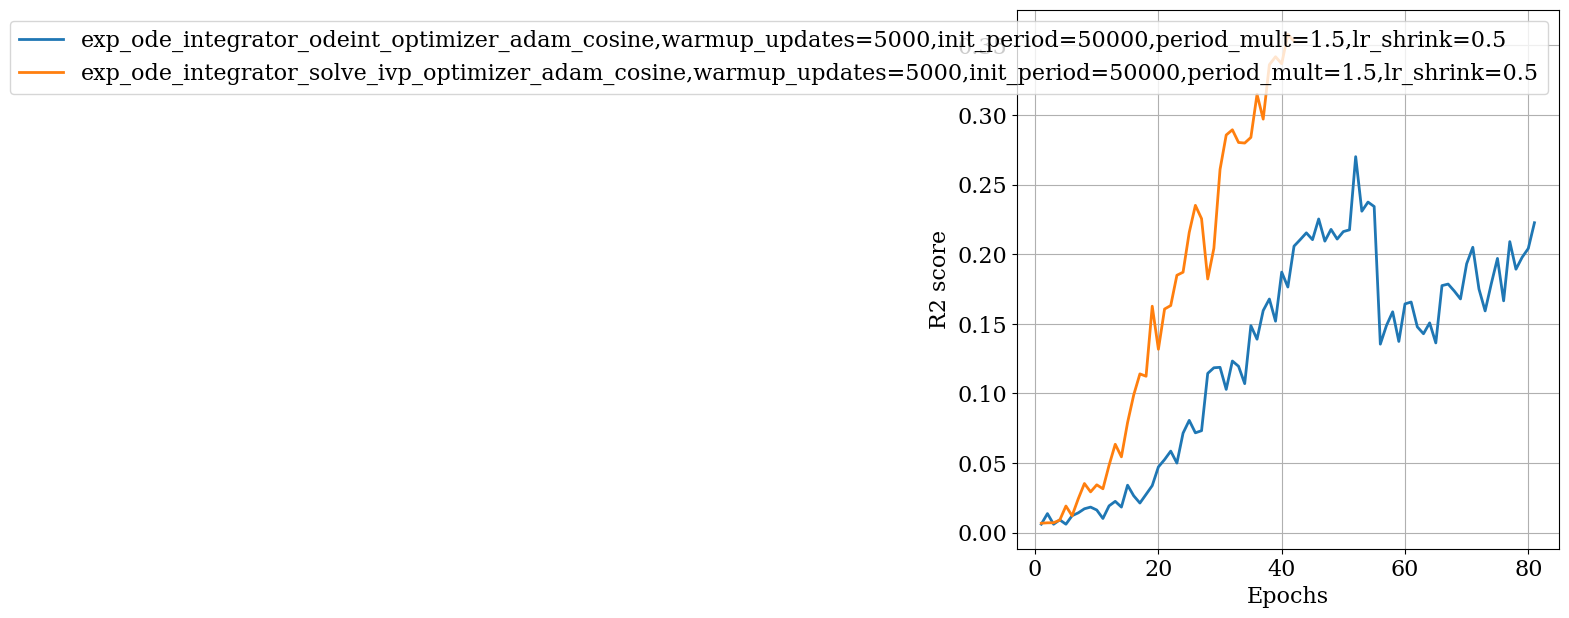

In [74]:
constraints = {
    'optimizer': ['adam_cosine,warmup_updates=5000,init_period=50000,period_mult=1.5,lr_shrink=0.5'],
}
selected_runs, selected_params = select_runs(runs, params, constraints)
latest = min([len(run['logs'])-1 for run in selected_runs])
#selected_runs = runs

plt.figure(figsize=(7,7))

for run in selected_runs[:]:
    args = run['args']
    times = np.array(range(len(run['logs'])))#[:latest]
    r2    = [run['logs'][t]['r2_zero']      for t in times]
    acc    = [run['logs'][t]['accuracy_l1_1e-1']      for t in times]
    label = args.exp_id
    #label = 'dim {}'.format(lab)
    y = acc
    #print(loss,correct,perfect,additional)
    plt.plot(times+1, y, label=label)

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('R2 score')
#plt.xscale('log')

plt.tight_layout()
#plt.savefig(savedir+'simplification_loss_{}.pdf'.format('float' if args.float_sequences else 'int'))
plt.show()

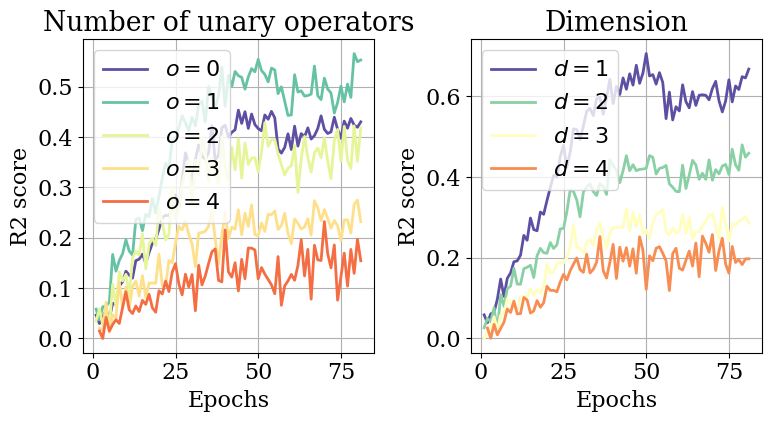

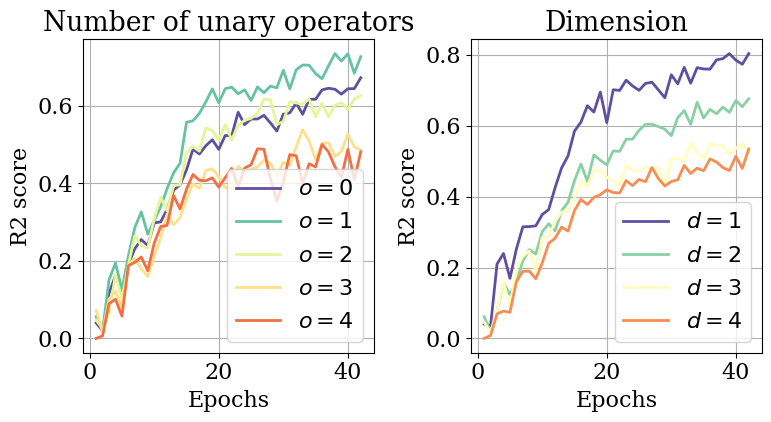

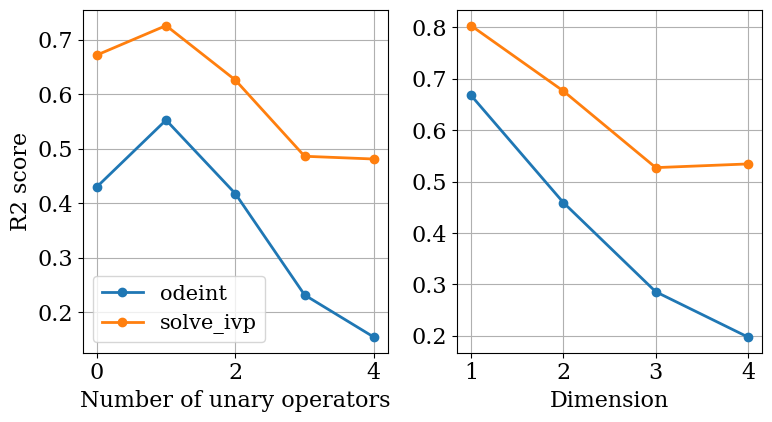

In [76]:
metrics = ['r2_zero_info_n_unary_ops', 'r2_zero_info_dimension']
legends = ['o', 'd']
labels = ['Number of unary operators', 'Dimension']

for run in selected_runs:
    if not run['logs']:continue
    args = run['args']
    fig, axarr = plt.subplots(1, len(metrics), figsize=(4*len(metrics),4.5))
    for i, metric in enumerate(metrics):
        keys = [k for k in run['logs'][0].keys() if metric in k]
        keys = keys[::max(1,len(keys)//5)]
        for j, key in enumerate(keys):
            label = int(key.split('_')[-1])
            if metric == 'additional': label = args.more_tolerance.split(',')[int(label)-1]
            for t in range(len(run['logs'])):
                if key not in run['logs'][t]: run['logs'][t][key] = 100
            acc = [run['logs'][t][key] for t in range(len(run['logs']))]
            axarr[i].plot(range(1, len(acc)+1), acc, label='${}={}$'.format(legends[i],label), color = cmap(j/len(keys)))
        axarr[i].set_title(labels[i])
        axarr[i].legend()
    for ax in axarr:
        #ax.set_xscale('log')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('R2 score')
    #for n, ax in enumerate(axarr):
    #    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
    plt.tight_layout()
    plt.savefig(savedir+'acc_vs_time.pdf')
    plt.show()    

##########       
    
suffix = ''
fig, axarr = plt.subplots(1, len(metrics), figsize=(4*len(metrics),4.5))
for run in selected_runs:
    if not run['logs']:continue
    args = run['args']
    log = run['logs'][-1]
    for i, metric in enumerate(metrics):
        keys = [k for k in run['logs'][0].keys() if metric in k]
        if metric == 'additional':
            x = [eval(x) for x in args.more_tolerance.split(',')]
            axarr[i].set_xscale('log')
        elif metric == 'ops':
            x = [int(k.split('_')[-1]) for k in keys]
        else:
            x = [int(k.split('_')[-1]) for k in keys]
        y = [log[k] for k in keys]
        label = args.ode_integrator
        axarr[i].plot(x, y, label = label, marker='o')
        axarr[i].set_xlabel(r'{}'.format(labels[i]))
        #axarr[i].set_ylim(bottom=0, top=100)
        #axarr[i].set_yscale('symlog')
#for n, ax in enumerate(axarr):
#    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, size=20, weight='bold')
axarr[0].set_ylabel('R2 score')
axarr[0].legend(fontsize=15)
plt.tight_layout()
title = 'acc_vs_difficulty.pdf'
plt.savefig(savedir+title)
plt.show()    

In [77]:
run = runs[0]
args = run['args']
csv_path = args.dump_path + '/evals_all/eval_in_domain.csv'
df = pd.read_csv(csv_path)
for i in range(len(df)):
    sample = df.iloc[i]
    if sample['info_dimension']!=2: continue
    prefix = sample['trees']
    pred_prefix = sample['predicted_trees']
    print("True",prefix)
    print("Pred",pred_prefix, sample['r2_zero'])
    if i==100: break

True (1.35 add ((-6.5200000000000005 mul x_1) sub (((0.161 mul cos((0.887 add (0.9 mul x_0)))) sub (-96.30000000000001 mul t)) add (-9.98 mul x_1)))) | (51.300000000000004 add (((-26.5 mul inv((0.515 add (-5.48 mul x_1)))) add (-73.9 mul t)) add (30.6 mul x_0)))
Pred (-99.0 add (0.79 mul x_0)) | (0.6 add (x_0 mul ((0.4 mul x_0) add (31.6 mul x_1)))) 0.9969972562588864
True (2.82 add ((-0.249 mul (x_0 mul ((2.09 mul (x_0 mul t)) add (9.65 mul t)))) add (-0.321 mul x_1))) | (8.5 add ((8.1 mul (x_1 mul x_0)) add ((-88.10000000000001 mul (x_0 mul x_1)) sub (0.792 mul x_1))))
Pred (3.0 add (-3.3000000000000003 mul (t mul x_0))) | (5.2 add ((-49.0 mul x_1) sub (-0.1 mul (((0.4 mul x_0) sub (4.5 mul x_0)) mul t)))) 0.1872826280401824
True (9.64 add ((3.65 mul x_1) sub (((0.746 mul x_0) add (-0.202 mul t)) add ((37.5 mul (x_0 mul t)) add (-1.12 mul x_1))))) | (-1.17 add (1.25 mul x_0))
Pred (0.05 add (-1.4000000000000001 mul x_0)) | (-0.9 add (0.9 mul x_0)) 0.5818783098529372
True (0.193 add (

# Load model

In [113]:
run = selected_runs[-1]
args = run['args']
extra_args = {'rescale':True}
dstr = load_run(run, extra_args=extra_args)

Reloading checkpoint from /scratch/dascoli/odeformer/experiments/first/exp_ode_integrator_solve_ivp_optimizer_adam_cosine,warmup_updates=5000,init_period=50000,period_mult=1.5,lr_shrink=0.5/checkpoint.pth ...
Reloading checkpoint optimizer ...
Checkpoint reloaded. Resuming at epoch 44 / iteration 44000 ...


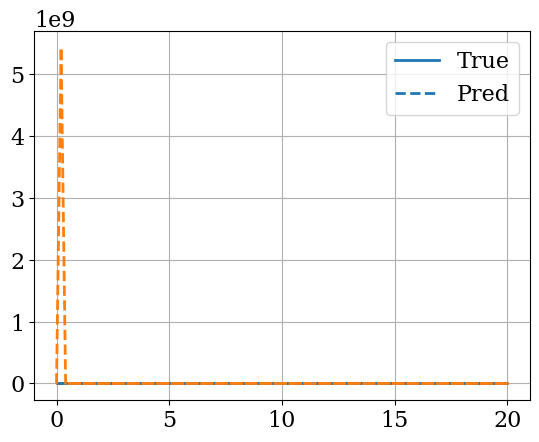

In [186]:
dstr.rescale = True
a = 1.5 # growth rate of rabbits
b = 1 # death rate of rabbits
c = 3 # death rate of foxes
d = 1 # growth rate of foxes
def lotka_volterra(X, t):
    """ Return the growth rate of fox and rabbit populations. """
    return np.array([ a*X[0] - b*X[0]*X[1] ,
                     -c*X[1] + d*X[0]*X[1] ])

# solve ODE
times = np.linspace(0,20,100)     # time
y0 = [10,10] # initials conditions
trajectory = integrate.odeint(lotka_volterra, y0, times)
# plot results
plt.plot(times, trajectory[:,0], color='C0', label='True')
plt.plot(times, trajectory[:,1], color='C1')

candidates = dstr.fit(times, trajectory)
tree = candidates[0][0]

pred_trajectory = integrate_ode(tree, y0, times, "odeint")
plt.plot(times, pred_trajectory[:,0], color='C0', ls='--', label='Pred')
plt.plot(times, pred_trajectory[:,1], color='C1', ls='--')
plt.legend()
plt.show()

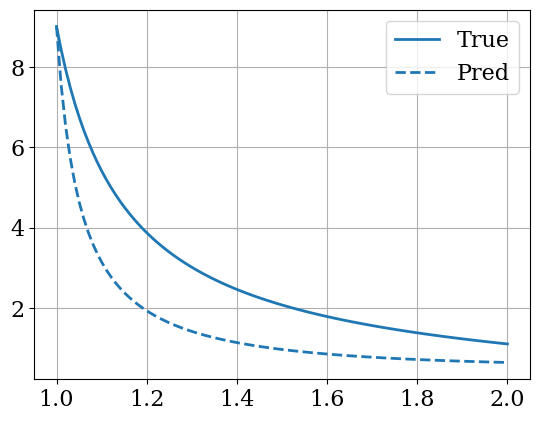

In [89]:
a = -0.76
b = .23
c = -0.5
def quadratic(X, t):
    """ Return the growth rate of fox and rabbit populations. """
    return np.array([a*X[0]**2+b*X[0]+c])

# solve ODE
times = np.linspace(1, 2, 100)     # time
y0 = [9] # initials conditions
trajectory = integrate.odeint(quadratic, y0, times)
# plot results
plt.plot(times, trajectory[:,0], color='C0', label='True')

candidates = dstr.fit(times, trajectory)
tree = candidates[0][0]
pred_trajectory = integrate_ode(tree, y0, times, "odeint")
plt.plot(times, pred_trajectory[:,0], color='C0', ls='--', label='Pred')
plt.legend()
plt.show()

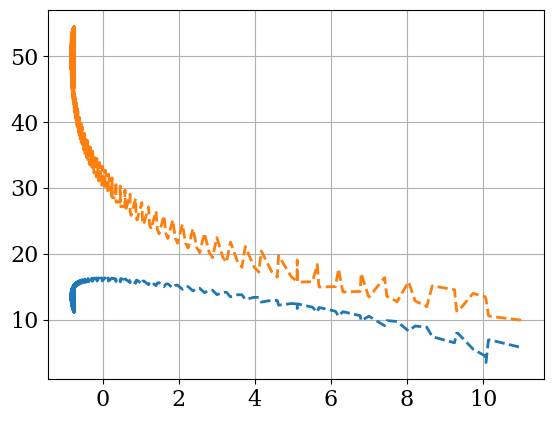

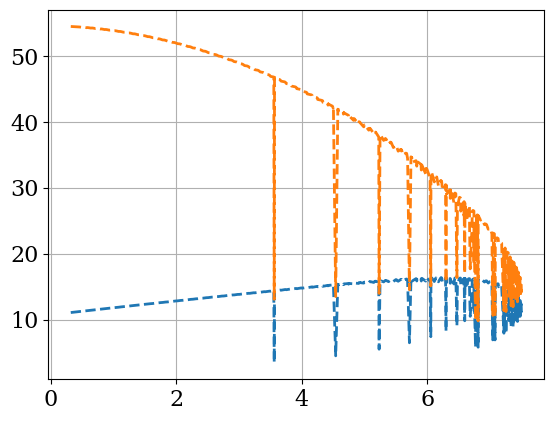

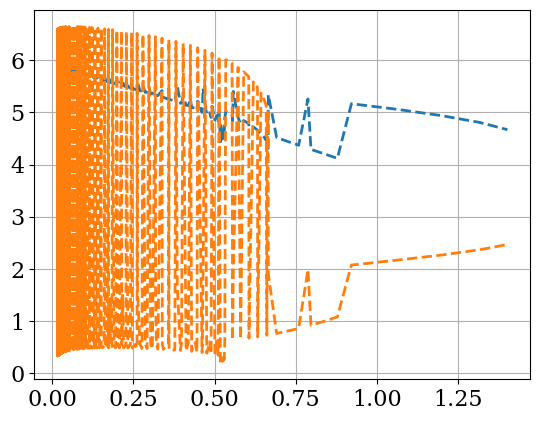

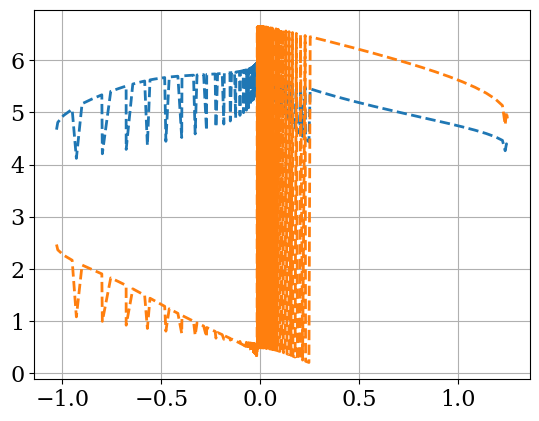

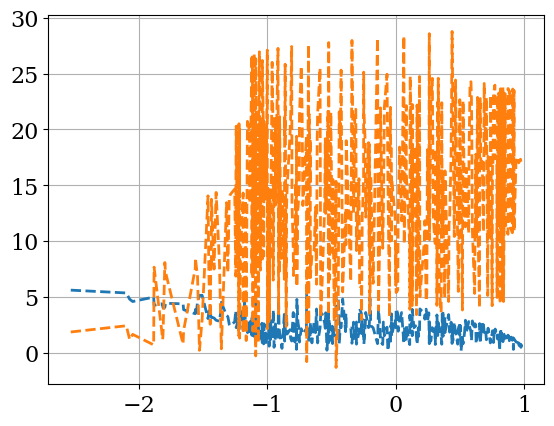

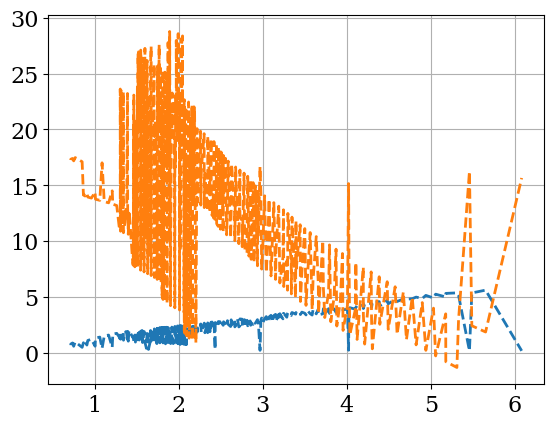

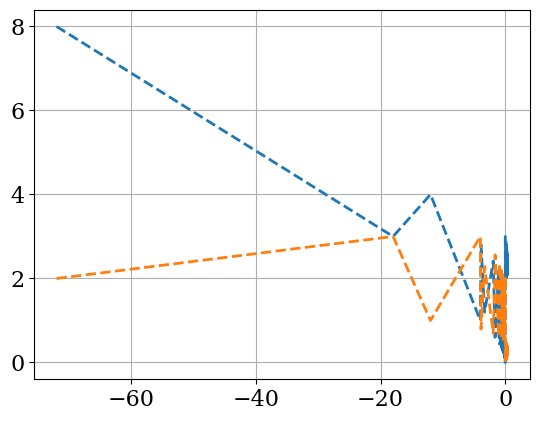

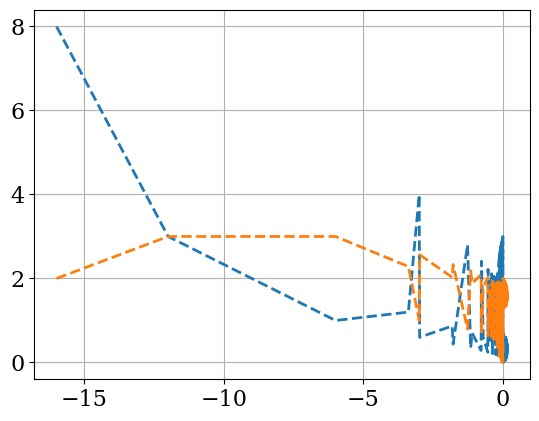

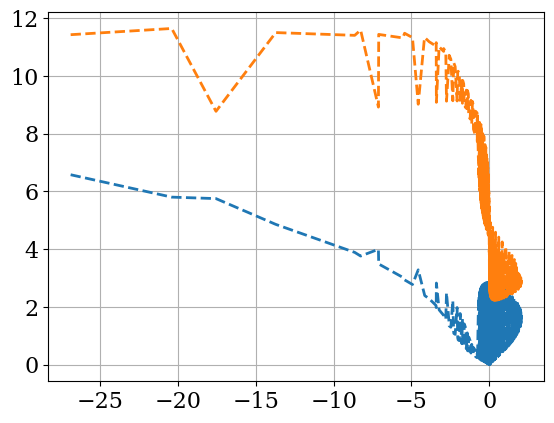

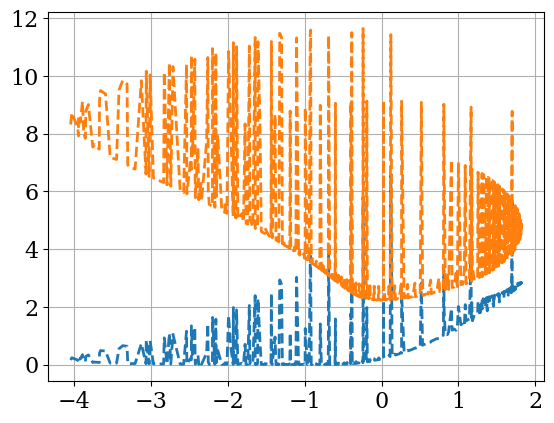

In [59]:
from pmlb import fetch_data, dataset_names
strogatz_names = [name for name in dataset_names if "strogatz" in name]

# Returns a pandas DataFrame
for name in strogatz_names[:10]:
    data = fetch_data(name)
    times = data['target'].values
    trajectory = data[['x','y']].values
    # order trajectory by increasing times
    trajectory = trajectory[np.argsort(times)]
    times = sorted(times)
    #plt.plot(trajectory[:,0], trajectory[:,1], color='C0', ls='--')
    plt.plot(times, trajectory[:,0], color='C0', ls='--')
    plt.plot(times, trajectory[:,1], color='C1', ls='--')
    plt.show()

In [52]:
times

array([-0.38719634, -0.92782758, -1.30027014, -1.60765543, -1.88594807,
       -2.15528061, -2.42865962, -2.71361476, -3.01084386, -3.31089637,
       -3.59066401, -3.8140439 , -3.94234616, -3.95312043, -3.85311482,
       -3.67244267, -3.44712037, -3.20605304, -2.9676184 , -2.7416524 ,
       -2.53249593, -2.34137093, -2.16788051, -2.01086774, -1.86888065,
       -1.74041286, -1.62402133, -1.51837813, -1.42228781, -1.33468726,
       -1.25463734, -1.18131105, -1.11398087, -1.05200639, -0.99482304,
       -0.94193177, -0.89289012, -0.84730419, -0.80482175, -0.7651261 ,
       -0.72793069, -0.69297431, -0.66001679, -0.62883508, -0.59921955,
       -0.57097055, -0.54389502, -0.51780316, -0.49250502, -0.46780694,
       -0.44350779, -0.41939499, -0.39524006, -0.37079393, -0.34578177,
       -0.31989748, -0.29279793, -0.26409719, -0.23336106, -0.20010266,
       -0.16377982, -0.12379578, -0.07950483, -0.03022526,  0.02473788,
        0.08605738,  0.154334  ,  0.23003135,  0.31339839,  0.40

In [43]:
times

array([ 8.21314776e+00,  7.46869320e+00,  6.76900786e+00,  6.11739011e+00,
        5.51428085e+00,  4.95848500e+00,  4.44789085e+00,  3.97990312e+00,
        3.55170776e+00,  3.16043490e+00,  2.80325883e+00,  2.47745821e+00,
        2.18045072e+00,  1.90981135e+00,  1.66327988e+00,  1.43876152e+00,
        1.23432312e+00,  1.04818663e+00,  8.78720894e-01,  7.24432701e-01,
        5.83957378e-01,  4.56049433e-01,  3.39573411e-01,  2.33495110e-01,
        1.36873251e-01,  4.88516488e-02, -3.13480971e-02, -1.04433386e-01,
       -1.71046889e-01, -2.31772325e-01, -2.87139771e-01, -3.37630521e-01,
       -3.83681536e-01, -4.25689508e-01, -4.64014560e-01, -4.98983623e-01,
       -5.30893505e-01, -5.60013681e-01, -5.86588830e-01, -6.10841137e-01,
       -6.32972385e-01, -6.53165847e-01, -6.71588008e-01, -6.88390122e-01,
       -7.03709624e-01, -7.17671412e-01, -7.30389004e-01, -7.41965588e-01,
       -7.52494977e-01, -7.62062466e-01, -7.70745616e-01, -7.78614955e-01,
       -7.85734627e-01, -

# Play with generator

In [ ]:
parser = argparse.ArgumentParser(description="Function prediction", add_help=False)
FunctionEnvironment.register_args(parser)    
args = parser.parse_args(args=[])
args.max_dimension = 4
args.ode_integrator = 'solve_ivp'
    
env = FunctionEnvironment(args)

env.rng = np.random.RandomState()
for i in range(10):
    samples, error = env._gen_expr(train=True, dimension=4)
    if not error:
        tree = samples["tree"]
        tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
        for expr in tree_sympy:
            display(expr)
        plt.figure()
        for dim in range(samples["infos"]["dimension"]):
            plt.plot(samples["times"], samples["trajectory"][:, dim])
        plt.show()


In [ ]:
from scipy.integrate import odeint
tree, dimension, nb_unary_ops, nb_binary_ops = env.generator.generate_multi_dimensional_tree(rng=env.rng, dimension=3)
tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
print('System :')
for expr in tree_sympy:
    display(expr)
y0 = np.random.randn(dimension)
t = np.linspace(1,2,100)
def func(y,t):
    return tree.val([y],t)[0]
while True:
    import warnings
    with warnings.catch_warnings(record=True) as caught_warnings:
        sol = odeint(func, y0, t)
    if caught_warnings:
        print('hi')
        print('Warning: ', caught_warnings[0].message)
        continue
    break

for dim in range(dimension):
    plt.plot(t,sol[:,dim])


In [ ]:
from scipy.integrate import odeint, solve_ivp
tree, dimension, nb_unary_ops, nb_binary_ops = env.generator.generate_multi_dimensional_tree(rng=env.rng, dimension=2)
tree_sympy = env.simplifier.tree_to_sympy_expr(tree, round=True)
print('System :')
for expr in tree_sympy:
    display(expr)
y0 = np.random.randn(dimension)
t = (0,1)
def func(t,y):
    return tree.val([y],t)[0]
while True:
    import warnings
    with warnings.catch_warnings(record=True) as caught_warnings:
        #sol = odeint(func, y0, t)
        sol = solve_ivp(func, t, y0)
    if caught_warnings:
        print('hi')
        print('Warning: ', caught_warnings[0].message)
        continue
    break

t = sol.t
sol = sol.y.T
for dim in range(dimension):
    plt.plot(t,sol[:,dim])
